# Change point based Clustering

In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
SOCKSHOP_DATASET_ID = "9n6mf"

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    validation_filtering=(True, 4*5)
)

In [98]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "orders-db")][1]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape

orders-db/pod-memory-hog/4


(180, 179)

In [99]:
from tsdr.outlierdetection.spot import detect_anomalies_with_spot
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma

sli_data: pd.DataFrame = dataset.loc[
    :, [col for col in record.pk.get_root_metrics() if col in dataset.columns]
]  # retrieve only existing slis
most_anomalous_sli_name = sli_data.apply(lambda x: detect_anomalies_with_spot(x.to_numpy(), 4*30)[1]).idxmax()
most_anomalous_sli_data = sli_data[most_anomalous_sli_name].to_numpy()
most_anomalous_sli_name 

's-front-end_latency'

In [100]:
cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cols]

In [101]:
from tsdr.multireducer import change_point_clustering
from tsdr.smooth import moving_average

In [102]:
# from tsdr import tsdr

# tsdr.Tsdr(enable_unireducer=False, enable_multireducer=True, univariate_series_func_or_name="residual_integral",
#     step2_clustering_method_name="changepoint",
#     step2_changepoint_n_bkps=1,
#     step2_changepoint_proba_threshold=0.5,
#     step2_clustering_choice_method="max_members_changepoint",
#     step2_changepoint_cluster_selection_method="leaf",
#     step2_changepoint_cluster_selection_epsilon=3.0,
#     step2_changepoint_allow_single_cluster=True,
#     step2_clustering_n_workers=1,
# ).reduce_multivariate_series(
#     dataset,
#     record.pk,
#     n_workers=1,
# )

In [115]:
cinfo, remove_metrics = change_point_clustering(
    cause_dataset,
    n_bkps=1,
    proba_threshold=0.5,
    choice_method="max_members_changepoint",
    cluster_selection_epsilon=3.0,
    cluster_selection_method="leaf",
    cluster_allow_single_cluster=True,
    sli_data=sli_data,
    n_jobs=-1,
)
cinfo, remove_metrics

({'c-orders-db_cpu_system_seconds_total': [],
  'c-orders-db_network_transmit_bytes_total': [],
  'c-orders-db_fs_writes_bytes_total': [],
  'c-orders-db_blkio_device_usage_total': [],
  'c-orders-db_network_receive_packets_total': [],
  'c-orders-db_threads': [],
  'c-orders-db_memory_cache': [],
  'c-orders-db_memory_usage_bytes': [],
  'c-orders-db_cpu_cfs_throttled_periods_total': [],
  'c-orders-db_cpu_usage_seconds_total': [],
  'c-orders-db_fs_reads_total': [],
  'c-orders-db_cpu_user_seconds_total': [],
  'c-orders-db_fs_writes_total': [],
  'c-orders-db_network_receive_bytes_total': [],
  'c-orders-db_cpu_cfs_throttled_seconds_total': [],
  'c-orders-db_memory_mapped_file': [],
  'c-orders-db_network_transmit_packets_total': [],
  'c-orders-db_fs_reads_bytes_total': []},
 ['c-orders-db_memory_rss',
  'c-orders-db_last_seen',
  'c-orders-db_memory_working_set_bytes',
  'c-orders-db_cpu_cfs_periods_total'])

In [110]:
import ruptures as rpt
import hdbscan 
from hdbscan.prediction import all_points_membership_vectors, all_points_outlier_membership_vector

from collections import defaultdict
import itertools

In [111]:
# cause_dataset = cause_dataset.apply(lambda x: moving_average(x, window_size=5))
# sli_data = sli_data.apply(lambda x: moving_average(x, window_size=5))

162

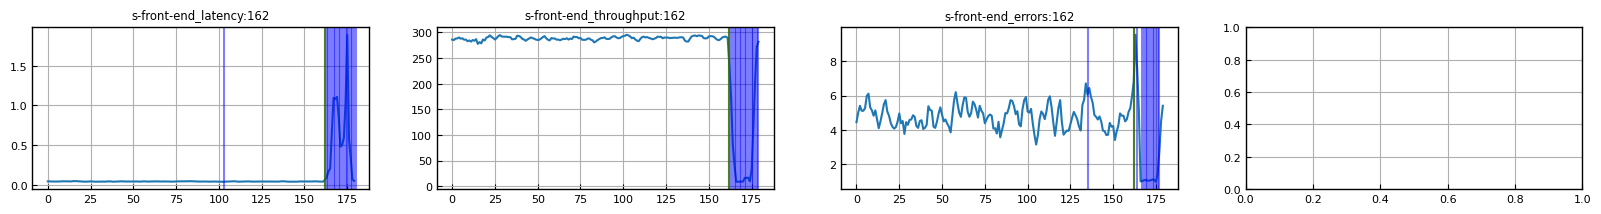

In [118]:
import math
from ruptures.costs import CostNormal

binseg = rpt.Binseg(custom_cost=CostNormal(add_small_diag=True), jump=1)
fig, axs = plt.subplots(math.ceil(sli_data.shape[1]/4), ncols=4)
fig.set_size_inches(20, 0.7*sli_data.shape[1])
bkps = []
for ax, sli in zip(axs.flatten(), sli_data.columns):
    sli_y = sli_data[sli].values
    bkp = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[0]
    bkps.append(bkp)
    ax.plot(sli_y)
    ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(f"{sli}:{bkp}")

    backward_idx = 4*20
    alarms, scores = detect_anomalies_with_spot(sli_y, anomalous_start_idx=backward_idx, return_score=True, proba=1e-4)
    # alarms, scores = detect_anomalies_with_zscore_nsigma(sli_y, anomalous_start_idx=backward_idx, return_score=True, n_sigmas=3.0, robust=True)
    for alarm in alarms:
        a = (sli_y.size - backward_idx) + alarm
        ax.axvline(a, color='blue', alpha=0.5)

    _bkps = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[:-1]
    for bkp in _bkps:
        ax.axvline(bkp, color='green', alpha=0.7)
    
slis_bkp: int = binseg.fit(sli_data.apply(scipy.stats.zscore).values).predict(n_bkps=1)[0]
slis_bkp

In [119]:
data = cause_dataset
n_bkps = 1

metrics = data.columns.tolist()
binseg = rpt.Binseg(model="normal", jump=1)
change_points: list[int] = []
for metric in metrics:
    x = data[metric].to_numpy()
    change_point = binseg.fit(scipy.stats.zscore(x)).predict(n_bkps=n_bkps)[0]
    change_points.append(change_point)
metric_to_bkp = {metric: bkp for metric, bkp in zip(metrics, change_points)}

print(
    "multivariate bkp",
    binseg.fit(data.apply(scipy.stats.zscore)).predict(n_bkps=n_bkps)[0],
)

cluster_selection_epsilon = 3.0
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    metric="euclidean",
    allow_single_cluster=True,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=cluster_selection_epsilon,
).fit(np.array([change_points]).T)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, clusterer.labels_, change_points, clusterer.outlier_scores_, clusterer.probabilities_), columns=["metric", "cluster_id", "change_point", "outlier_score", "probability"]))
print("persistence", clusterer.cluster_persistence_)


from dataclasses import dataclass
from collections import UserList


@dataclass
class ClusterMember:
    metric_name: str
    change_point: int
    proba: float

@dataclass
class Cluster:
    cluster_id: int  # -1 means a noise cluster
    centroid: int  # -1 means a noise cluster
    members: list[ClusterMember]

    @classmethod
    def from_raw_members(cls, cluster_id: int, centroid: int, members: list[tuple[str, int, float]]):
        return cls(cluster_id, centroid, [ClusterMember(*member) for member in members])

    def _has_near_members(self, target: ClusterMember, eps: int) -> bool:
        _members = sorted(self.members, key=lambda m: m.change_point)
        for _member in _members:
            if _member.change_point == target.change_point:
                continue
            if abs(_member.change_point - target.change_point) < eps:
                return True
        return False

    def _inliers(self, threshold: float = 0.0, eps: int = 1) -> list[ClusterMember]:
        assert 0 <= threshold <= 1
        return [m for m in self.members if m.proba >= threshold or self._has_near_members(m, eps)]
    
    def keep_only_inliers(self, threshold: float, eps: int) -> None:
        self.members = self._inliers(threshold, eps)
    
    def size(self) -> int:
        return len(self.members)


class Clusters(UserList[Cluster]):
    def __init__(self, clusters: list[Cluster]):
        super().__init__(UserList(clusters))

    @classmethod
    def from_raw_values(cls, clusterer: hdbscan.HDBSCAN, metrics: list[str], change_points: list[int]):
        _cluster_id_to_centroid = {
            cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
            for cluster_id in np.unique(clusterer.labels_)
            if cluster_id != -1  # skip noise cluster
        }
        _cluster_id_to_members = defaultdict(list)
        for label, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
            centroid: int = _cluster_id_to_centroid.get(label, -1)  # -1 means a noise cluster
            _cluster_id_to_members[(label, centroid)].append((metric, change_point, proba))

        clusters: list[Cluster] = []
        for (cluster_id, centroid), members in sorted(_cluster_id_to_members.items(), key=lambda x: x[0][1]):
            clusters.append(Cluster.from_raw_members(cluster_id, centroid, members))
        return Clusters(clusters)
    
    def inliner(self, threshold: float = 1.0, eps: int = 1, copy: bool = True):
        if copy:
            _orig_clusters = self.data
            return Clusters([Cluster(c.cluster_id, c.centroid, c._inliers(threshold=threshold, eps=eps)) for c in _orig_clusters if c.cluster_id != -1])
        else:
            for c in self:
                if c.cluster_id != -1:
                    self.data.remove(c)
                    continue
                c.keep_only_inliers(threshold=threshold, eps=eps)
            return self
    
    def cluster_of_max_size(self) -> Cluster:
        return max(self, key=lambda c: c.size())
    
    def noise(self) -> Cluster:
        return next(c for c in self.data if c.cluster_id == -1)
    

# cluster_id_to_centroid = {
#     cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
#     for cluster_id in np.unique(clusterer.labels_)
#     if cluster_id != -1  # skip noise cluster
# }
# cluster_id_to_change_points: dict[int, list[int]] = defaultdict(list)
# clusters_with_centroid: dict[tuple[int, int], list[str]] = defaultdict(list)
# # print(list(zip(clusterer.labels_, metrics, change_points)))
# for cluster_id, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
#     if cluster_id == -1:  # skip noise features
#         continue
#     centroid = cluster_id_to_centroid[cluster_id]
#     clusters_with_centroid[(cluster_id, centroid)].append(metric)
#     cluster_id_to_change_points[cluster_id].append(change_point)

# remove outliers
# for (cluster_id, centroid), members in clusters_with_centroid.items():
#     if proba <= 0.5 and :
#         continue
# # choose a cluster having max metrics and the adjacent clusters
# import pprint
# for x in clusters_with_centroid.items():
#     print(agglomerative_coefficient(np.array(cluster_id_to_change_points[x[0][0]], dtype=int), x[0][1]), x)

clusters = Clusters.from_raw_values(clusterer, metrics, change_points)
inliners = clusters.inliner(threshold=0.5, eps=int(cluster_selection_epsilon), copy=True)
keep_clusters = [inliners.cluster_of_max_size()]
print("keep_clusters", keep_clusters)

keep_metrics: list[str] = [m.metric_name for m in keep_clusters[0].members]
remove_metrics: list[str] = list(set(metrics) - set(keep_metrics))
clustering_info: dict[str, list[str]] = {metric: [] for metric in keep_metrics}
clustering_info, remove_metrics

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:28: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


multivariate bkp 161


,metric,cluster_id,change_point,outlier_score,probability
0,c-orders-db_cpu_cfs_throttled_periods_total,0,162,0.000000,1.0
1,c-orders-db_cpu_usage_seconds_total,0,162,0.000000,1.0
2,c-orders-db_fs_reads_total,0,162,0.000000,1.0
3,c-orders-db_memory_cache,0,162,0.000000,1.0
4,c-orders-db_memory_rss,-1,133,0.964286,0.0
5,c-orders-db_last_seen,-1,90,0.976744,0.0
6,c-orders-db_fs_writes_bytes_total,0,162,0.000000,1.0
7,c-orders-db_cpu_user_seconds_total,0,162,0.000000,1.0
8,c-orders-db_fs_writes_total,0,162,0.000000,1.0
9,c-orders-db_cpu_cfs_throttled_seconds_total,0,162,0.000000,1.0


persistence [1.]
keep_clusters [Cluster(cluster_id=0, centroid=162.11111111111111, members=[ClusterMember(metric_name='c-orders-db_cpu_cfs_throttled_periods_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_cpu_usage_seconds_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_fs_reads_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_memory_cache', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_fs_writes_bytes_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_cpu_user_seconds_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_fs_writes_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_cpu_cfs_throttled_seconds_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_fs_reads_bytes_total', change_point=162, proba=1.0), ClusterMember(metric_name='c-orders-db_cpu_system_seconds_total', chang

({'c-orders-db_cpu_cfs_throttled_periods_total': [],
  'c-orders-db_cpu_usage_seconds_total': [],
  'c-orders-db_fs_reads_total': [],
  'c-orders-db_memory_cache': [],
  'c-orders-db_fs_writes_bytes_total': [],
  'c-orders-db_cpu_user_seconds_total': [],
  'c-orders-db_fs_writes_total': [],
  'c-orders-db_cpu_cfs_throttled_seconds_total': [],
  'c-orders-db_fs_reads_bytes_total': [],
  'c-orders-db_cpu_system_seconds_total': [],
  'c-orders-db_blkio_device_usage_total': [],
  'c-orders-db_network_transmit_bytes_total': [],
  'c-orders-db_network_receive_bytes_total': [],
  'c-orders-db_memory_usage_bytes': [],
  'c-orders-db_memory_mapped_file': [],
  'c-orders-db_network_transmit_packets_total': [],
  'c-orders-db_network_receive_packets_total': [],
  'c-orders-db_threads': []},
 ['c-orders-db_memory_rss',
  'c-orders-db_last_seen',
  'c-orders-db_memory_working_set_bytes',
  'c-orders-db_cpu_cfs_periods_total'])

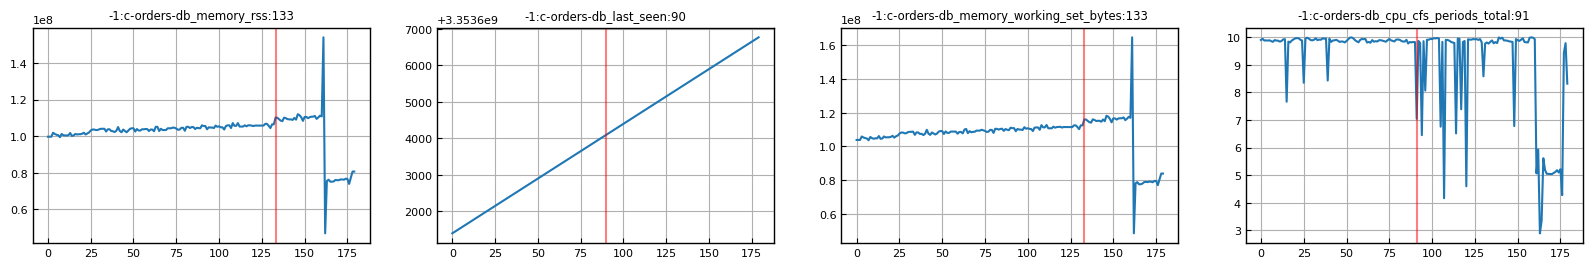

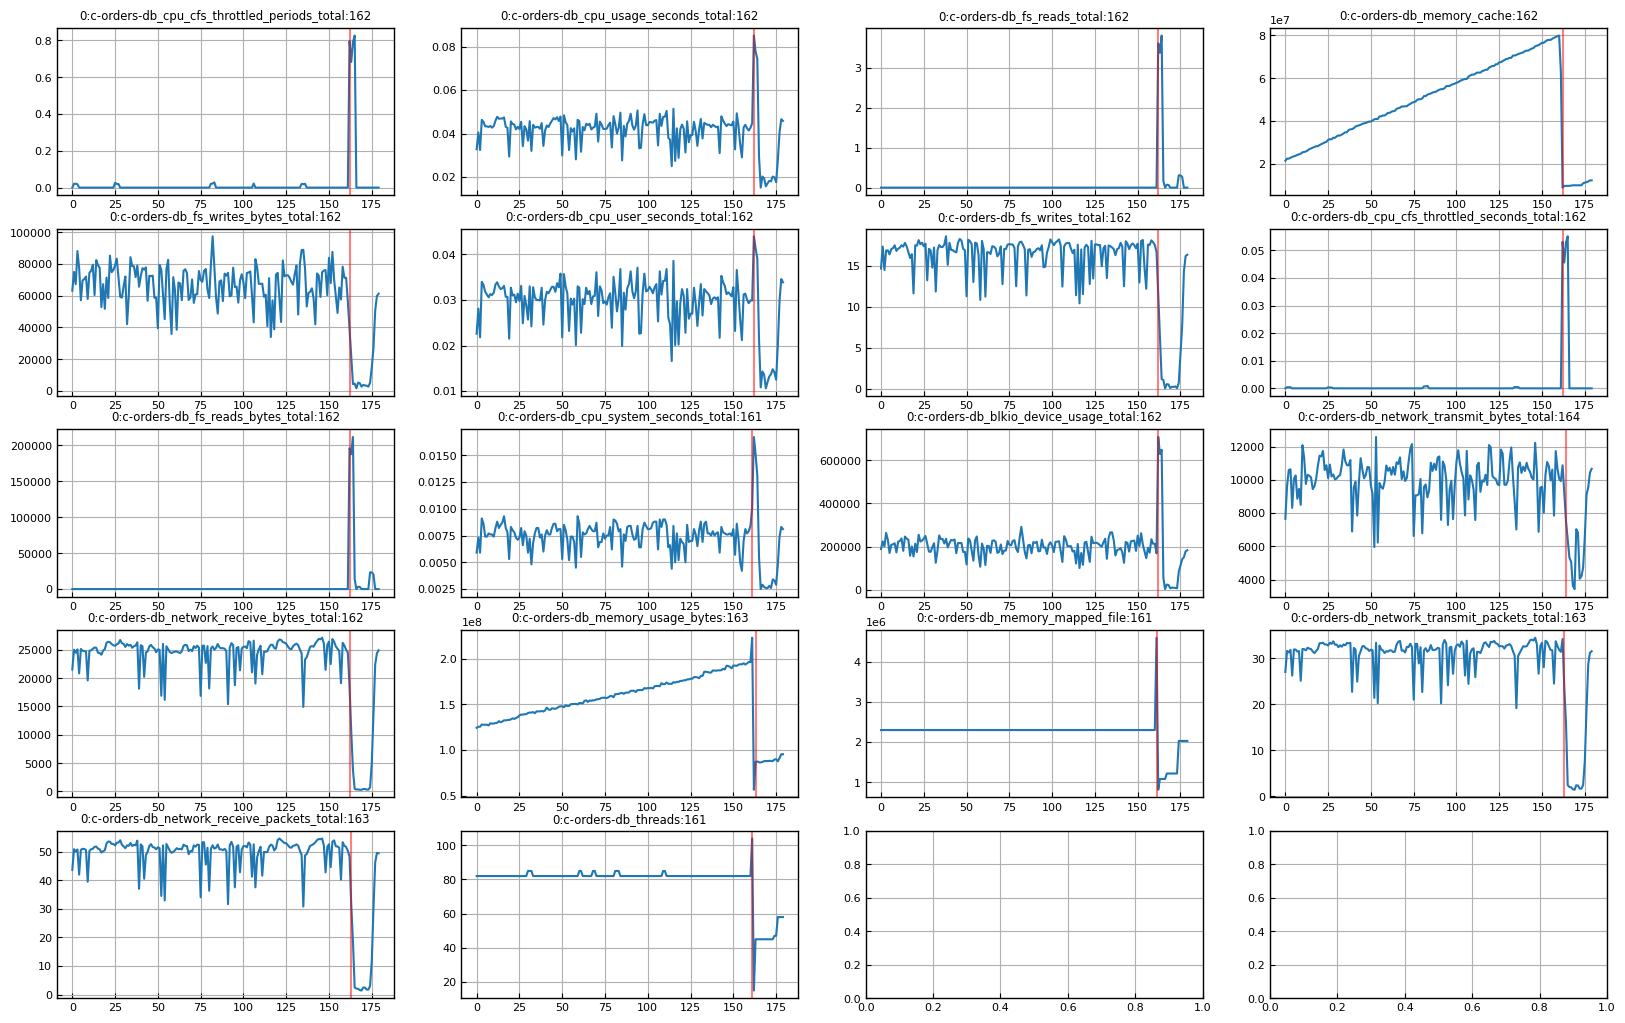

In [120]:
import math
from notebooklib import plot

plt.close()

for cluster in clusters:
    fig, axs = plt.subplots(math.ceil(cluster.size()/4), ncols=4)
    fig.set_size_inches(20, 0.7*cluster.size())
    for ax, member in zip(axs.flatten(), cluster.members):
        metric = member.metric_name
        x = cause_dataset[metric].to_numpy()
        ax.plot(x)
        ax.axvline(member.change_point, color='red', alpha=0.5)
        ax.set_title(f"{cluster.cluster_id}:{metric}:{member.change_point}")